# **5. Uso de tecnicas de optimizacion computacional a los modelos Benchmark**

## **5.0 Previo a probar tecnicas de optimizacion**

In [21]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import math
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report
)

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## **5.1 Técnicas de optimización para KNN**

In [22]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [23]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [25]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [27]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    """Evalúa un modelo y grafica sus métricas principales"""
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n🔹 {nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

### **5.1.1 KNN estándar**

In [28]:
resultados_knn = []


start = time.time()
knn_std = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])
knn_std.fit(X_train, y_train)
y_pred_std = knn_std.predict(X_test)
end = time.time()
metrics_std = {
    "Modelo": "KNN - Benchmark",
    "Accuracy": accuracy_score(y_test, y_pred_std),
    "Precision": precision_score(y_test, y_pred_std),
    "Recall": recall_score(y_test, y_pred_std),
    "F1": f1_score(y_test, y_pred_std),
    "Tiempo (s)": round(end - start, 3)
}
resultados_knn.append(metrics_std)

### **5.1.2 KNN usando KD-Trees**

In [29]:
start = time.time()
knn_kd = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree", n_jobs=-1))
])
knn_kd.fit(X_train, y_train)
y_pred_kd = knn_kd.predict(X_test)
end = time.time()
metrics_kd = {
    "Modelo": "KNN - KDTree",
    "Accuracy": accuracy_score(y_test, y_pred_kd),
    "Precision": precision_score(y_test, y_pred_kd),
    "Recall": recall_score(y_test, y_pred_kd),
    "F1": f1_score(y_test, y_pred_kd),
    "Tiempo (s)": round(end - start, 3)
}
resultados_knn.append(metrics_kd)

### **5.1.3 KNN usando Ball Trees**

In [30]:
start = time.time()
knn_ball = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=5, algorithm="ball_tree", n_jobs=-1))
])
knn_ball.fit(X_train, y_train)
y_pred_ball = knn_ball.predict(X_test)
end = time.time()
metrics_ball = {
    "Modelo": "KNN - BallTree",
    "Accuracy": accuracy_score(y_test, y_pred_ball),
    "Precision": precision_score(y_test, y_pred_ball),
    "Recall": recall_score(y_test, y_pred_ball),
    "F1": f1_score(y_test, y_pred_ball),
    "Tiempo (s)": round(end - start, 3)
}
resultados_knn.append(metrics_ball)

### **5.1.4 KNN usando FAISS**

In [31]:
import faiss

start = time.time()
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

d = X_train_proc.shape[1]
index = faiss.IndexFlatL2(d)
index.add(np.array(X_train_proc, dtype=np.float32))

k = 5
distances, indices = index.search(np.array(X_test_proc, dtype=np.float32), k)

y_pred_faiss = []
for idxs in indices:
    vecinos = y_train.iloc[idxs]
    voto = int(vecinos.mean() >= 0.5)
    y_pred_faiss.append(voto)

end = time.time()
metrics_faiss = {
    "Modelo": "KNN - FAISS",
    "Accuracy": accuracy_score(y_test, y_pred_faiss),
    "Precision": precision_score(y_test, y_pred_faiss),
    "Recall": recall_score(y_test, y_pred_faiss),
    "F1": f1_score(y_test, y_pred_faiss),
    "Tiempo (s)": round(end - start, 3)
}
resultados_knn.append(metrics_faiss)


### **5.1.5 Resultados para KNN y sus metodos de optimizacion**

In [32]:
tabla_resultados = pd.DataFrame(resultados_knn).sort_values("F1", ascending=False).reset_index(drop=True)
print(tabla_resultados)

            Modelo  Accuracy  Precision    Recall        F1  Tiempo (s)
0     KNN - KDTree  0.582686   0.551938  0.502398  0.526004      70.096
1  KNN - Benchmark  0.582244   0.551309  0.502825  0.525952       2.179
2   KNN - BallTree  0.582244   0.551309  0.502825  0.525952       9.655
3      KNN - FAISS  0.582244   0.551321  0.502718  0.525899      11.322


C:\Users\taran\AppData\Local\Temp\ipykernel_14552\3770232650.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="F1", data=tabla_resultados, palette="Reds")


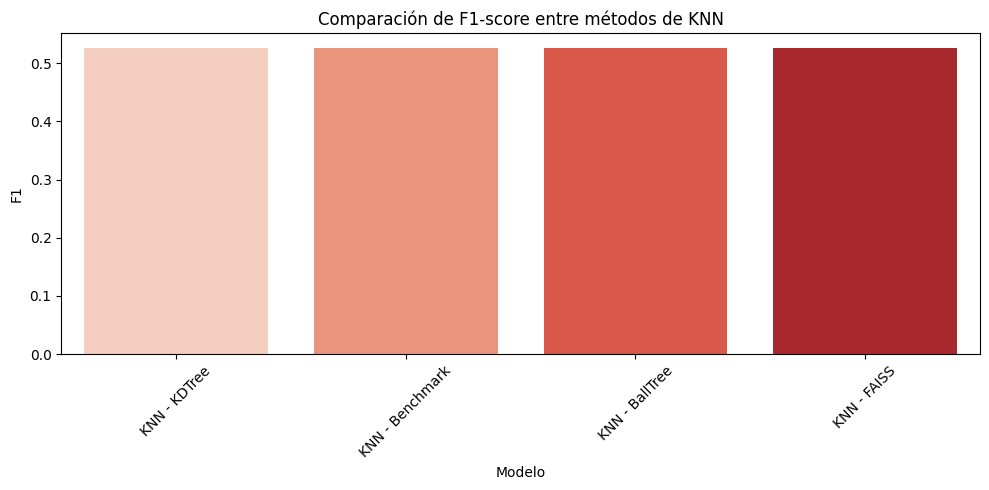

In [33]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="F1", data=tabla_resultados, palette="Reds")
plt.title("Comparación de F1-score entre métodos de KNN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_14552\4080304565.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Tiempo (s)", data=tabla_resultados, palette="Reds")


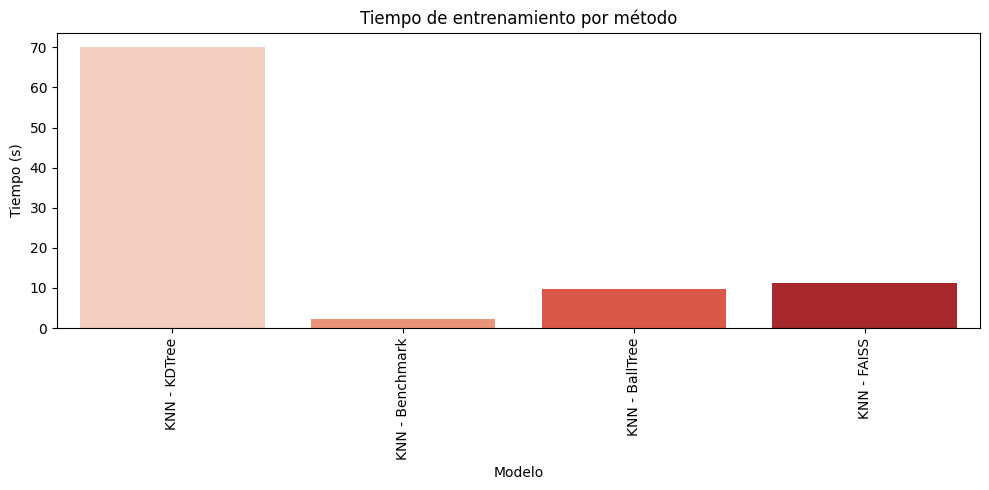

In [34]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="Tiempo (s)", data=tabla_resultados, palette="Reds")
plt.title("Tiempo de entrenamiento por método")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## **5.2 Técnicas de optimización para Clasificador Bayesiano**

Se selccionan las variables explicativas y la respuesta.

In [35]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [36]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [38]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [40]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n{nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


### **5.2.1 Clasificador Bayesiano estándar**

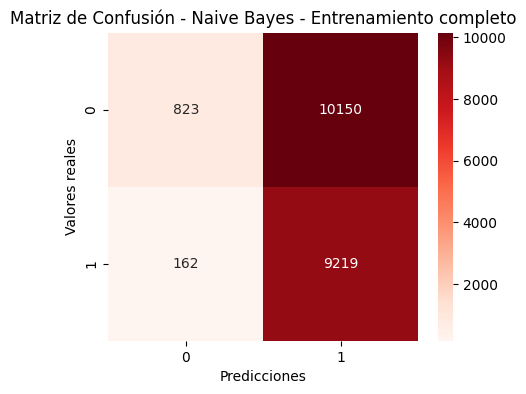


Naive Bayes - Entrenamiento completo
Accuracy: 0.493 | Precision: 0.476 | Recall: 0.983 | F1: 0.641
AUC: 0.642
              precision    recall  f1-score   support

           0       0.84      0.08      0.14     10973
           1       0.48      0.98      0.64      9381

    accuracy                           0.49     20354
   macro avg       0.66      0.53      0.39     20354
weighted avg       0.67      0.49      0.37     20354



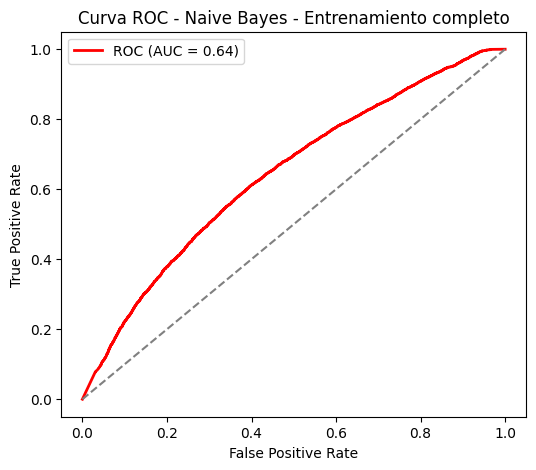

In [41]:
t0 = time.time()
bayes_normal = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GaussianNB())
])

bayes_normal.fit(X_train, y_train)
t1 = time.time()

result_bayes_normal = evaluar_modelo(bayes_normal, X_test, y_test, "Naive Bayes - Entrenamiento completo")
result_bayes_normal["Tiempo (s)"] = round(t1 - t0, 3)

### **5.2.2 Clasificador Bayesiano usando partial_fit()**

In [42]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

nb_incremental = GaussianNB()
clases = np.unique(y_train)
batch_size = 2000
t0 = time.time()

for i in range(0, len(X_train_proc), batch_size):
    X_batch = X_train_proc[i:i + batch_size]
    y_batch = y_train.iloc[i:i + batch_size]
    nb_incremental.partial_fit(X_batch, y_batch, classes=clases)

t1 = time.time()

In [43]:
y_pred = nb_incremental.predict(X_test_proc)
y_pred_proba = nb_incremental.predict_proba(X_test_proc)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

In [44]:
print("\n Naive Bayes Incremental (Partial Fit)")
print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")

result_bayes_incremental = {
    "Modelo": "Naive Bayes Incremental",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "AUC": auc,
    "Tiempo (s)": round(t1 - t0, 3)
}


 Naive Bayes Incremental (Partial Fit)
Accuracy: 0.494 | Precision: 0.476 | Recall: 0.983 | F1: 0.641 | AUC: 0.642


### **5.2.3 Resultados para Clasificador Bayesiano y sus metodos de optimizacion**

In [45]:
tabla_resultados = pd.DataFrame([
    result_bayes_normal,
    result_bayes_incremental
])
print("\n Comparación de modelos:")
print(tabla_resultados)


 Comparación de modelos:
                                 Modelo  Accuracy  Precision    Recall  \
0  Naive Bayes - Entrenamiento completo  0.493367   0.475967  0.982731   
1               Naive Bayes Incremental  0.493515   0.476040  0.982731   

         F1       AUC  Tiempo (s)  
0  0.641322  0.642233       0.856  
1  0.641389  0.642218       0.192  


C:\Users\taran\AppData\Local\Temp\ipykernel_14552\3546648994.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="F1", data=tabla_resultados, palette="Reds")


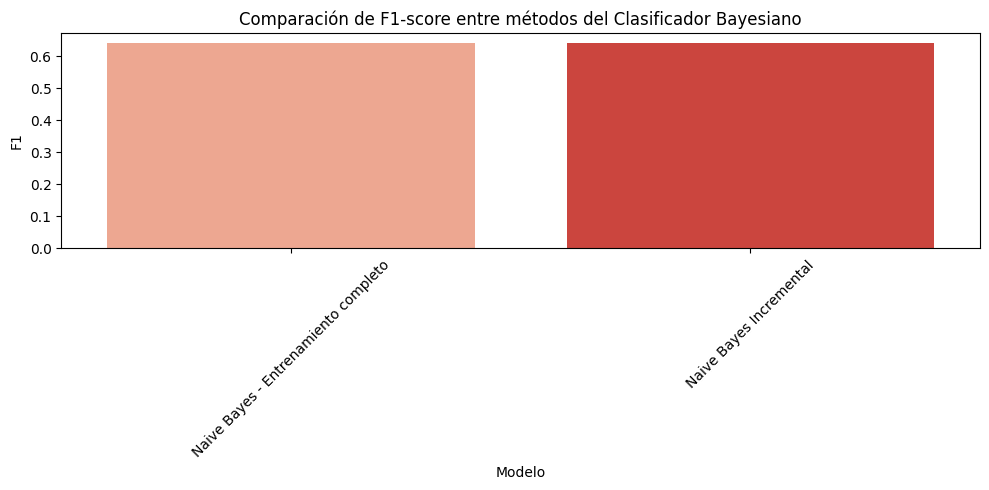

In [47]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="F1", data=tabla_resultados, palette="Reds")
plt.title("Comparación de F1-score entre métodos del Clasificador Bayesiano")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_14552\631096664.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Tiempo (s)", data=tabla_resultados, palette="Reds")


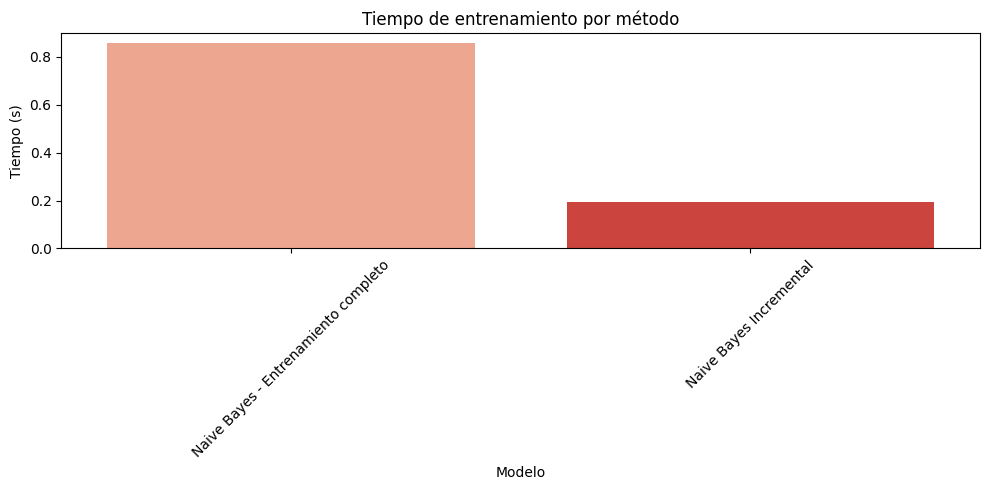

In [48]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="Tiempo (s)", data=tabla_resultados, palette="Reds")
plt.title("Tiempo de entrenamiento por método")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **5.3 Técnicas de optimización para Regresión Logistica (L1/L2)**

In [49]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [50]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [52]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [53]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [54]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n{nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


### **5.3.1 Regresion Logistica (L1/L2) estándar**

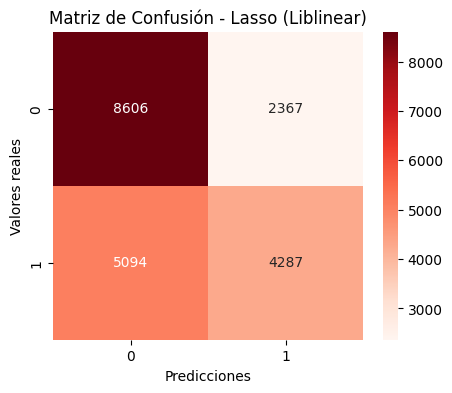


Lasso (Liblinear)
Accuracy: 0.633 | Precision: 0.644 | Recall: 0.457 | F1: 0.535
AUC: 0.681
              precision    recall  f1-score   support

           0       0.63      0.78      0.70     10973
           1       0.64      0.46      0.53      9381

    accuracy                           0.63     20354
   macro avg       0.64      0.62      0.62     20354
weighted avg       0.64      0.63      0.62     20354



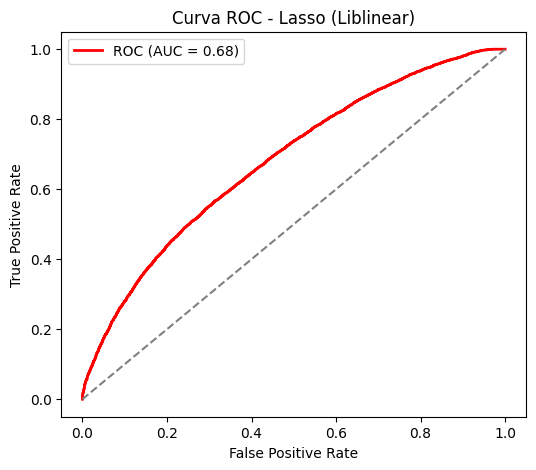

In [55]:
# 🔹 Lasso estándar (solver 'liblinear')
start = time.time()
lasso_std = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000, random_state=42))
])
lasso_std.fit(X_train, y_train)
end = time.time()
metrics_lasso_std = evaluar_modelo(lasso_std, X_test, y_test, "Lasso (Liblinear)")
metrics_lasso_std["Tiempo (s)"] = round(end - start, 3)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:319: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


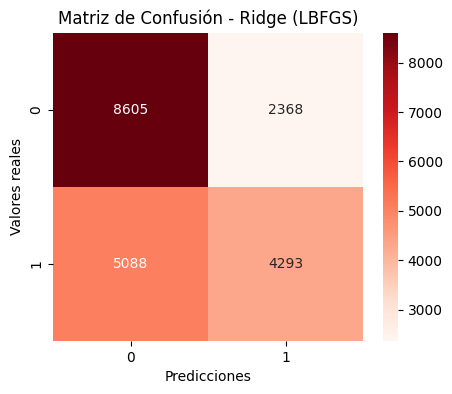


Ridge (LBFGS)
Accuracy: 0.634 | Precision: 0.644 | Recall: 0.458 | F1: 0.535
AUC: 0.681
              precision    recall  f1-score   support

           0       0.63      0.78      0.70     10973
           1       0.64      0.46      0.54      9381

    accuracy                           0.63     20354
   macro avg       0.64      0.62      0.62     20354
weighted avg       0.64      0.63      0.62     20354



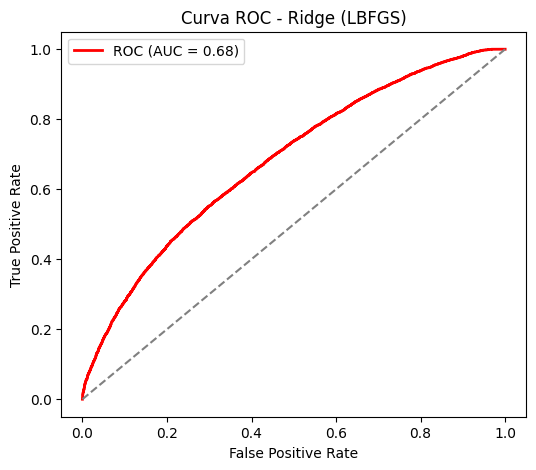

In [56]:
start = time.time()
ridge_std = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=1000, random_state=42))
])
ridge_std.fit(X_train, y_train)
end = time.time()
metrics_ridge_std = evaluar_modelo(ridge_std, X_test, y_test, "Ridge (LBFGS)")
metrics_ridge_std["Tiempo (s)"] = round(end - start, 3)


### **5.3.2 Regresion Logistica (L1/L2) usando solver=saga**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


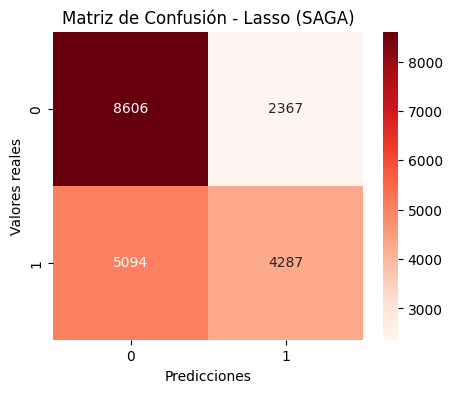


Lasso (SAGA)
Accuracy: 0.633 | Precision: 0.644 | Recall: 0.457 | F1: 0.535
AUC: 0.681
              precision    recall  f1-score   support

           0       0.63      0.78      0.70     10973
           1       0.64      0.46      0.53      9381

    accuracy                           0.63     20354
   macro avg       0.64      0.62      0.62     20354
weighted avg       0.64      0.63      0.62     20354



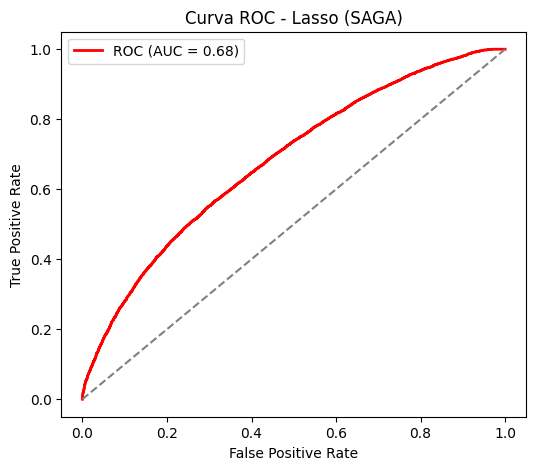

In [57]:
start = time.time()
lasso_saga = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(penalty="l1", solver="saga", max_iter=1000, random_state=42, n_jobs=-1))
])
lasso_saga.fit(X_train, y_train)
end = time.time()
metrics_lasso_saga = evaluar_modelo(lasso_saga, X_test, y_test, "Lasso (SAGA)")
metrics_lasso_saga["Tiempo (s)"] = round(end - start, 3)


c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


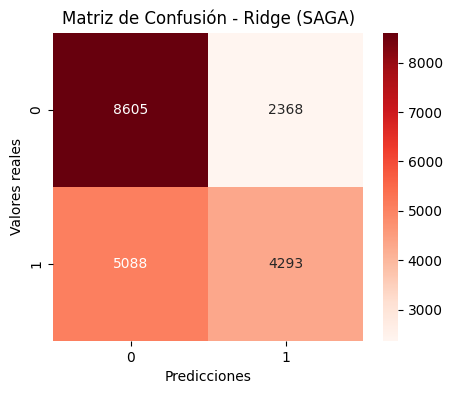


Ridge (SAGA)
Accuracy: 0.634 | Precision: 0.644 | Recall: 0.458 | F1: 0.535
AUC: 0.681
              precision    recall  f1-score   support

           0       0.63      0.78      0.70     10973
           1       0.64      0.46      0.54      9381

    accuracy                           0.63     20354
   macro avg       0.64      0.62      0.62     20354
weighted avg       0.64      0.63      0.62     20354



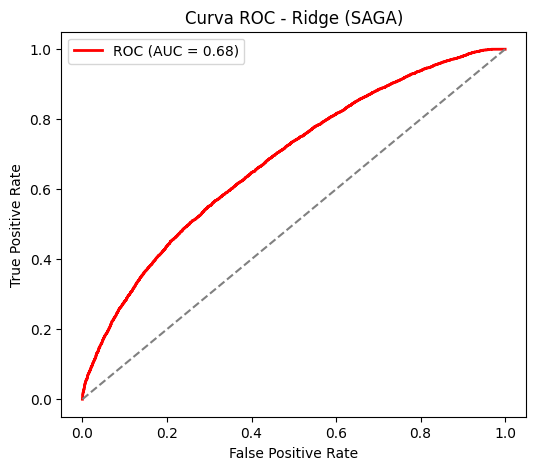

In [58]:
start = time.time()
ridge_saga = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(penalty="l2", solver="saga", max_iter=1000, random_state=42, n_jobs=-1))
])
ridge_saga.fit(X_train, y_train)
end = time.time()
metrics_ridge_saga = evaluar_modelo(ridge_saga, X_test, y_test, "Ridge (SAGA)")
metrics_ridge_saga["Tiempo (s)"] = round(end - start, 3)

### **5.3.3 Resultados para Regresion Logistica y sus metodos de optimizacion**

In [59]:
resultados = pd.DataFrame([
    metrics_ridge_std, metrics_ridge_saga,
    metrics_lasso_std, metrics_lasso_saga
])

print("\n🔍 Resultados comparativos (Ridge/Lasso con SAGA):")
print(resultados.sort_values("F1", ascending=False).reset_index(drop=True))


🔍 Resultados comparativos (Ridge/Lasso con SAGA):
              Modelo  Accuracy  Precision    Recall        F1       AUC  \
0      Ridge (LBFGS)  0.633684   0.644498  0.457627  0.535220  0.681092   
1       Ridge (SAGA)  0.633684   0.644498  0.457627  0.535220  0.681084   
2  Lasso (Liblinear)  0.633438   0.644274  0.456988  0.534705  0.681109   
3       Lasso (SAGA)  0.633438   0.644274  0.456988  0.534705  0.681112   

   Tiempo (s)  
0      15.303  
1     102.169  
2      10.713  
3     120.287  


C:\Users\taran\AppData\Local\Temp\ipykernel_14552\2618539691.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="F1", data=resultados, palette="Reds")


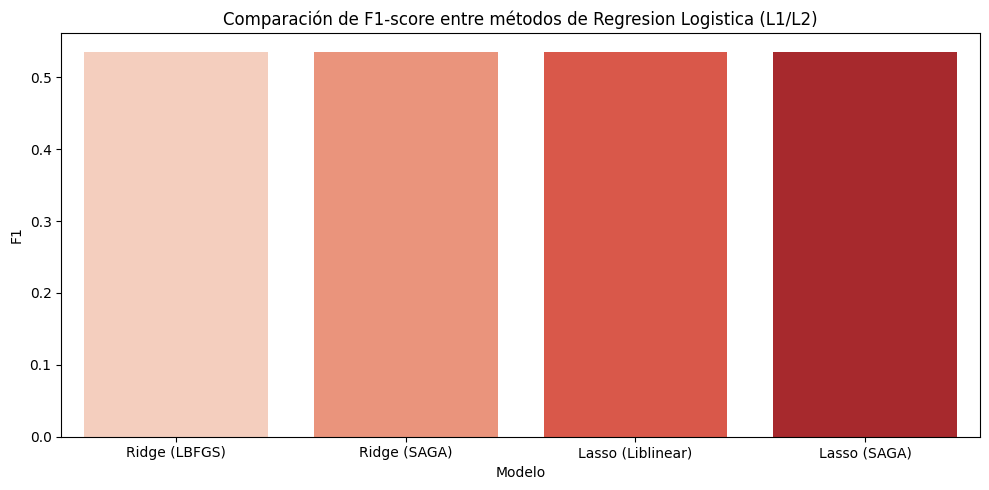

In [60]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="F1", data=resultados, palette="Reds")
plt.title("Comparación de F1-score entre métodos de Regresion Logistica (L1/L2)")
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_14552\163497550.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Tiempo (s)", data=resultados, palette="Reds")


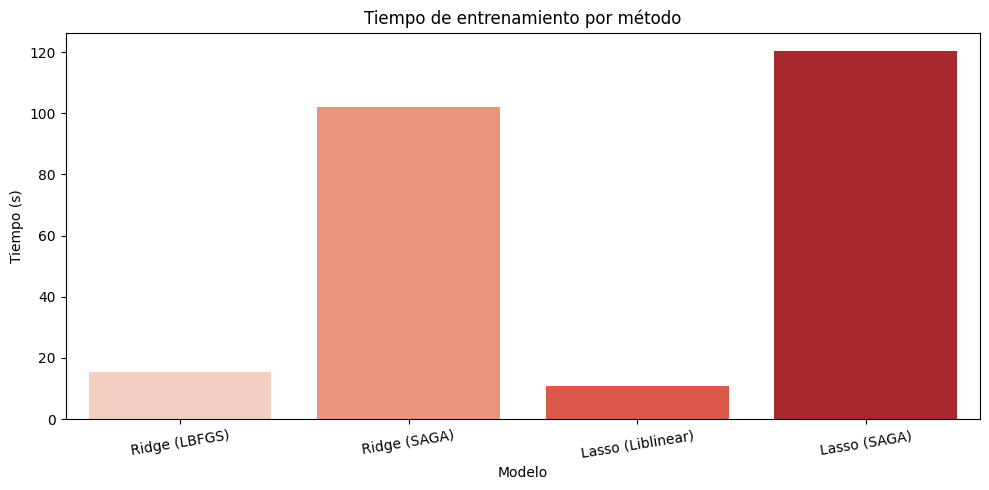

In [61]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="Tiempo (s)", data=resultados, palette="Reds")
plt.title("Tiempo de entrenamiento por método")
plt.xticks(rotation=9)
plt.tight_layout()
plt.show()

## **5.4 Técnicas de optimización para XGBoost**

In [62]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [63]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [65]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [66]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [67]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n{nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


### **5.4.1 XGBoost estándar**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


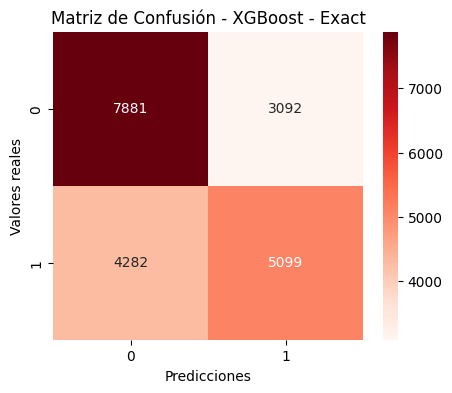


XGBoost - Exact
Accuracy: 0.638 | Precision: 0.623 | Recall: 0.544 | F1: 0.580
AUC: 0.686
              precision    recall  f1-score   support

           0       0.65      0.72      0.68     10973
           1       0.62      0.54      0.58      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.63     20354



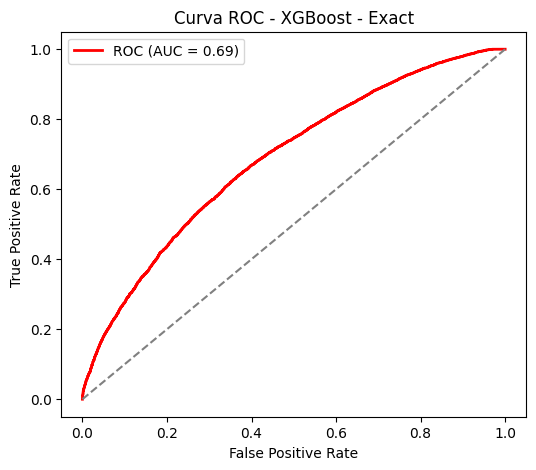

In [68]:
resultados_xgb = []

start = time.time()
xgb_exact = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="exact",
        use_label_encoder=False,
        random_state=42,
        n_estimators=200
    ))
])
xgb_exact.fit(X_train, y_train)
end = time.time()

metrics_exact = evaluar_modelo(xgb_exact, X_test, y_test, "XGBoost - Exact")
metrics_exact["Tiempo (s)"] = round(end - start, 3)
resultados_xgb.append(metrics_exact)

### **5.4.2 XGBoost usando tree_method=’hist’**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


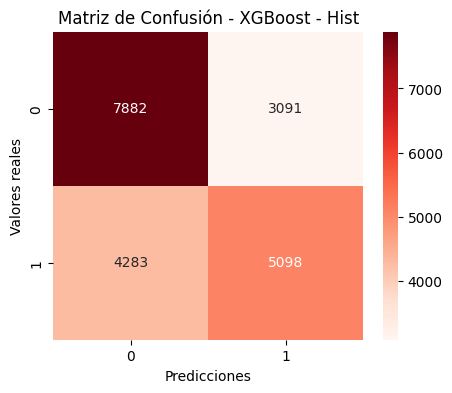


XGBoost - Hist
Accuracy: 0.638 | Precision: 0.623 | Recall: 0.543 | F1: 0.580
AUC: 0.686
              precision    recall  f1-score   support

           0       0.65      0.72      0.68     10973
           1       0.62      0.54      0.58      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.63     20354



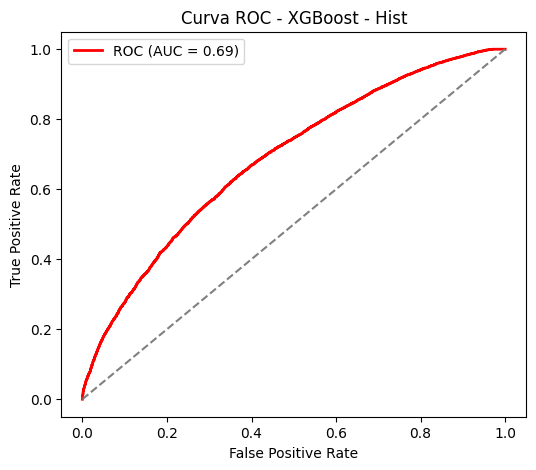

In [69]:
start = time.time()
xgb_hist = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        use_label_encoder=False,
        random_state=42,
        n_estimators=200
    ))
])
xgb_hist.fit(X_train, y_train)
end = time.time()

metrics_hist = evaluar_modelo(xgb_hist, X_test, y_test, "XGBoost - Hist")
metrics_hist["Tiempo (s)"] = round(end - start, 3)
resultados_xgb.append(metrics_hist)

### **5.4.3 XGBoost usando tree_method=’gpu_hist’**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:21:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0

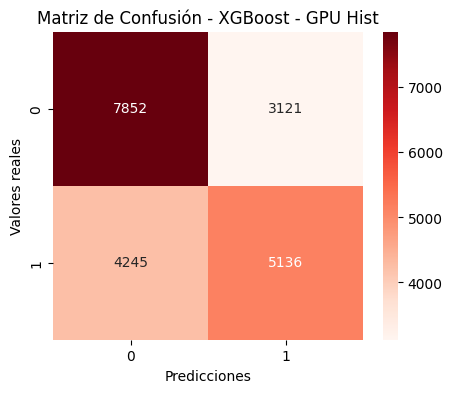


XGBoost - GPU Hist
Accuracy: 0.638 | Precision: 0.622 | Recall: 0.547 | F1: 0.582
AUC: 0.685
              precision    recall  f1-score   support

           0       0.65      0.72      0.68     10973
           1       0.62      0.55      0.58      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.64     20354



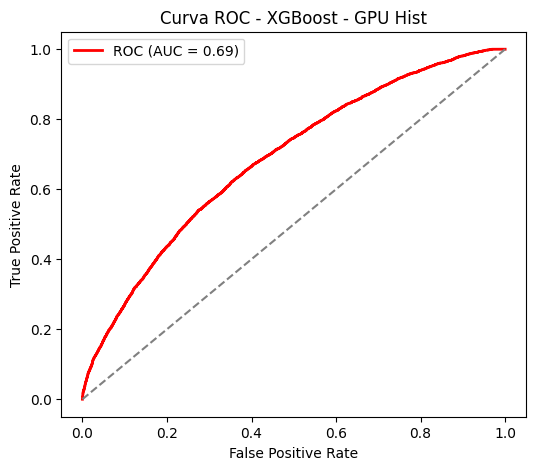

In [70]:
try:
    start = time.time()
    xgb_gpu = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="gpu_hist",
            use_label_encoder=False,
            random_state=42,
            n_estimators=200
        ))
    ])
    xgb_gpu.fit(X_train, y_train)
    end = time.time()

    metrics_gpu = evaluar_modelo(xgb_gpu, X_test, y_test, "XGBoost - GPU Hist")
    metrics_gpu["Tiempo (s)"] = round(end - start, 3)
    resultados_xgb.append(metrics_gpu)
except Exception as e:
    print("⚠️ GPU no disponible o error en XGBoost GPU:", e)

### **5.4.4 XGBoost usando tree_method=’hist’ y Regularizacion (L1/L2)**

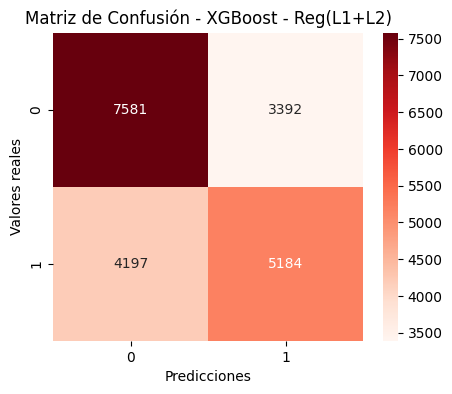


XGBoost - Reg(L1+L2)
Accuracy: 0.627 | Precision: 0.604 | Recall: 0.553 | F1: 0.577
AUC: 0.676
              precision    recall  f1-score   support

           0       0.64      0.69      0.67     10973
           1       0.60      0.55      0.58      9381

    accuracy                           0.63     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.63      0.63      0.63     20354



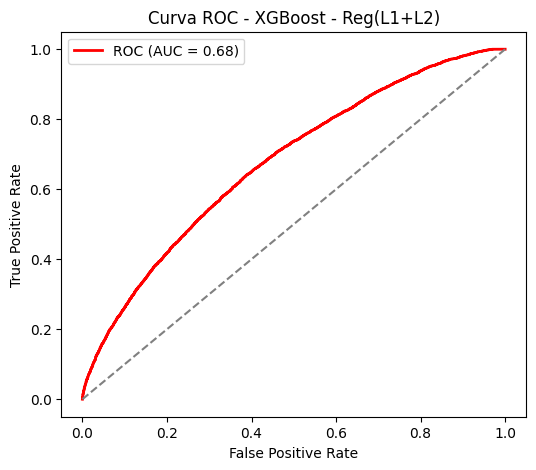

In [71]:
start = time.time()
xgb_reg = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    reg_lambda=5.0,
    reg_alpha=2.0,
    n_estimators=500,
    random_state=42
)
xgb_reg.fit(preprocessor.fit_transform(X_train), y_train)
end = time.time()

metrics_reg = evaluar_modelo(xgb_reg, preprocessor.transform(X_test), y_test, "XGBoost - Reg(L1+L2)")
metrics_reg["Tiempo (s)"] = round(end - start, 3)
resultados_xgb.append(metrics_reg)


### **5.4.5 Resultados para XGBoost y sus metodos de optimizacion**

In [72]:
tabla_resultados = pd.DataFrame(resultados_xgb).sort_values("F1", ascending=False).reset_index(drop=True)
print("\n Resultados comparativos - XGBoost optimizadas:\n")
print(tabla_resultados)


 Resultados comparativos - XGBoost optimizadas:

                 Modelo  Accuracy  Precision    Recall        F1       AUC  \
0    XGBoost - GPU Hist  0.638106   0.622018  0.547490  0.582379  0.685457   
1       XGBoost - Exact  0.637712   0.622513  0.543545  0.580355  0.686378   
2        XGBoost - Hist  0.637712   0.622542  0.543439  0.580307  0.686419   
3  XGBoost - Reg(L1+L2)  0.627149   0.604478  0.552606  0.577379  0.675655   

   Tiempo (s)  
0       2.184  
1       8.135  
2       1.576  
3       2.664  


C:\Users\taran\AppData\Local\Temp\ipykernel_14552\1333202125.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="F1", data=tabla_resultados, palette="Reds")


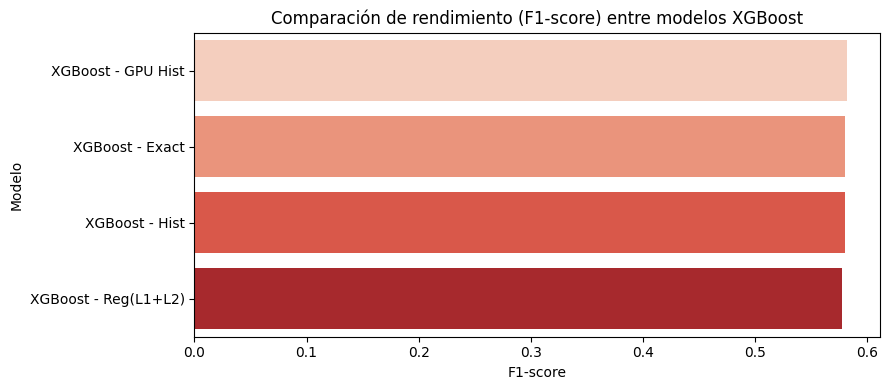

In [73]:
plt.figure(figsize=(9, 4))
sns.barplot(y="Modelo", x="F1", data=tabla_resultados, palette="Reds")
plt.title("Comparación de rendimiento (F1-score) entre modelos XGBoost")
plt.xlabel("F1-score")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_14552\3899611922.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="Tiempo (s)", data=tabla_resultados, palette="Reds")


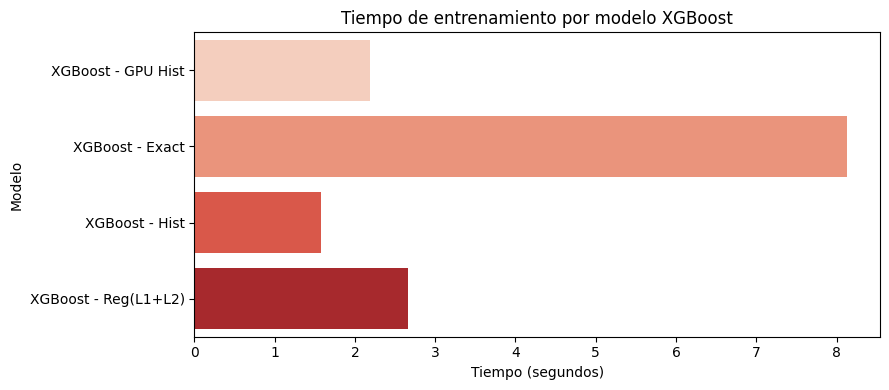

In [74]:
plt.figure(figsize=(9, 4))
sns.barplot(y="Modelo", x="Tiempo (s)", data=tabla_resultados, palette="Reds")
plt.title("Tiempo de entrenamiento por modelo XGBoost")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

## **5.5 Técnicas de optimización para SVM**

In [75]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [76]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [78]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [79]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [80]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    """Evalúa un modelo y grafica sus métricas principales"""
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n🔹 {nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

### **5.5.1 SVM estándar**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


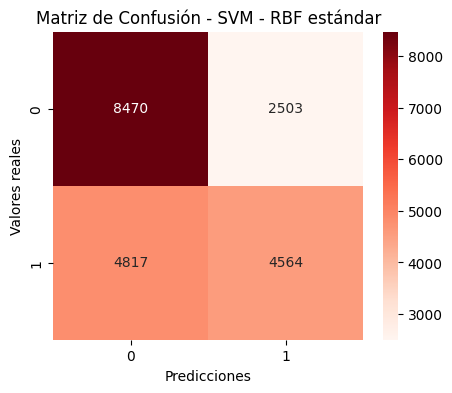


🔹 SVM - RBF estándar
Accuracy: 0.640 | Precision: 0.646 | Recall: 0.487 | F1: 0.555
AUC: 0.692
              precision    recall  f1-score   support

           0       0.64      0.77      0.70     10973
           1       0.65      0.49      0.55      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.63     20354



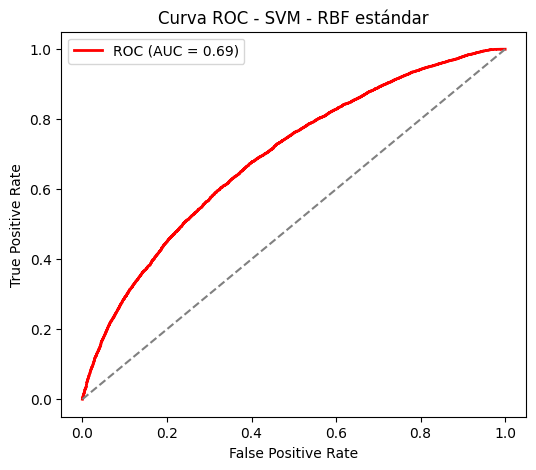

In [81]:
start = time.time()
svm_rbf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(kernel="rbf", gamma="scale", C=1.0, probability=True))
])
svm_rbf.fit(X_train, y_train)
end = time.time()
metrics_rbf = evaluar_modelo(svm_rbf, X_test, y_test, "SVM - RBF estándar")
metrics_rbf["Tiempo (s)"] = round(end - start, 3)

### **5.5.2 SVM usando LinearSVC**

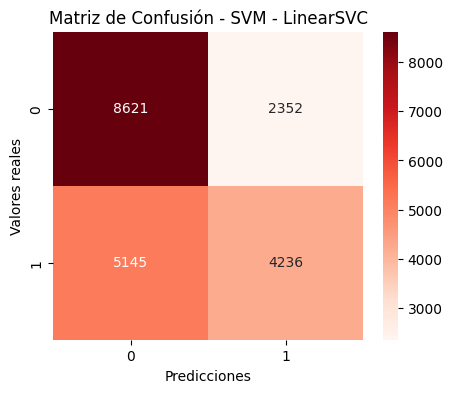


🔹 SVM - LinearSVC
Accuracy: 0.632 | Precision: 0.643 | Recall: 0.452 | F1: 0.531
              precision    recall  f1-score   support

           0       0.63      0.79      0.70     10973
           1       0.64      0.45      0.53      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.62      0.61     20354
weighted avg       0.63      0.63      0.62     20354



In [82]:
start = time.time()
svm_linear = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LinearSVC(C=1.0, max_iter=2000, dual=False))
])
svm_linear.fit(X_train, y_train)
end = time.time()
metrics_linear = evaluar_modelo(svm_linear, X_test, y_test, "SVM - LinearSVC")
metrics_linear["Tiempo (s)"] = round(end - start, 3)


### **5.5.3 SVM usando SGDClassifier**

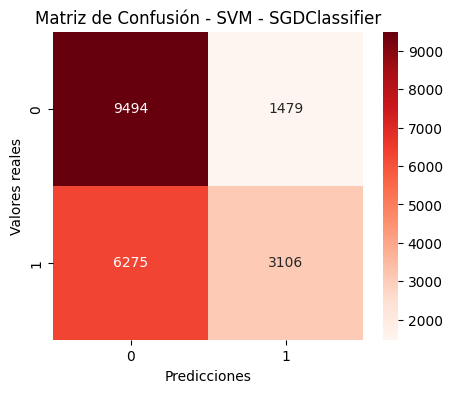


🔹 SVM - SGDClassifier
Accuracy: 0.619 | Precision: 0.677 | Recall: 0.331 | F1: 0.445
              precision    recall  f1-score   support

           0       0.60      0.87      0.71     10973
           1       0.68      0.33      0.44      9381

    accuracy                           0.62     20354
   macro avg       0.64      0.60      0.58     20354
weighted avg       0.64      0.62      0.59     20354



In [83]:
start = time.time()
svm_sgd = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SGDClassifier(loss="hinge", alpha=0.0001, max_iter=1000, random_state=42))
])
svm_sgd.fit(X_train, y_train)
end = time.time()
metrics_sgd = evaluar_modelo(svm_sgd, X_test, y_test, "SVM - SGDClassifier")
metrics_sgd["Tiempo (s)"] = round(end - start, 3)

### **5.5.4 SVM usando RBF con RFF**

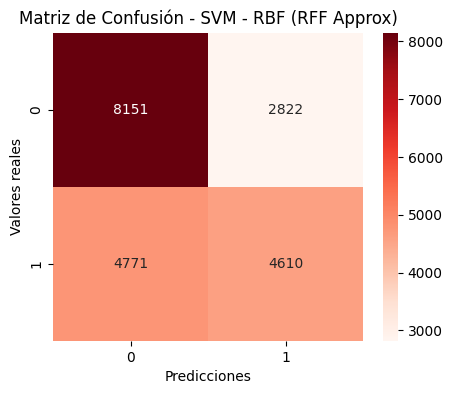


🔹 SVM - RBF (RFF Approx)
Accuracy: 0.627 | Precision: 0.620 | Recall: 0.491 | F1: 0.548
              precision    recall  f1-score   support

           0       0.63      0.74      0.68     10973
           1       0.62      0.49      0.55      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.62      0.62     20354
weighted avg       0.63      0.63      0.62     20354



In [84]:
start = time.time()
svm_rff = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rff", RBFSampler(gamma=0.1, n_components=500, random_state=42)),
    ("classifier", LinearSVC(C=1.0, max_iter=2000, dual=False))
])
svm_rff.fit(X_train, y_train)
end = time.time()
metrics_rff = evaluar_modelo(svm_rff, X_test, y_test, "SVM - RBF (RFF Approx)")
metrics_rff["Tiempo (s)"] = round(end - start, 3)

### **5.5.5 Resultados para SVM y sus metodos de optimizacion**

In [85]:
resultados_svm = pd.DataFrame([
    metrics_rbf,
    metrics_linear,
    metrics_sgd,
    metrics_rff
])

In [86]:
tabla_resultados = resultados_svm.sort_values("F1", ascending=False).reset_index(drop=True)
print("\n Resultados comparativos - SVM optimizadas:\n")
print(tabla_resultados)



 Resultados comparativos - SVM optimizadas:

                   Modelo  Accuracy  Precision    Recall        F1       AUC  \
0      SVM - RBF estándar  0.640366   0.645819  0.486515  0.554961  0.691903   
1  SVM - RBF (RFF Approx)  0.626953   0.620291  0.491419  0.548385       NaN   
2         SVM - LinearSVC  0.631669   0.642987  0.451551  0.530528       NaN   
3     SVM - SGDClassifier  0.619043   0.677426  0.331095  0.444795       NaN   

   Tiempo (s)  
0      94.512  
1      12.089  
2       9.653  
3       2.142  


C:\Users\taran\AppData\Local\Temp\ipykernel_14552\4005850654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="F1", data=tabla_resultados, palette="Reds")


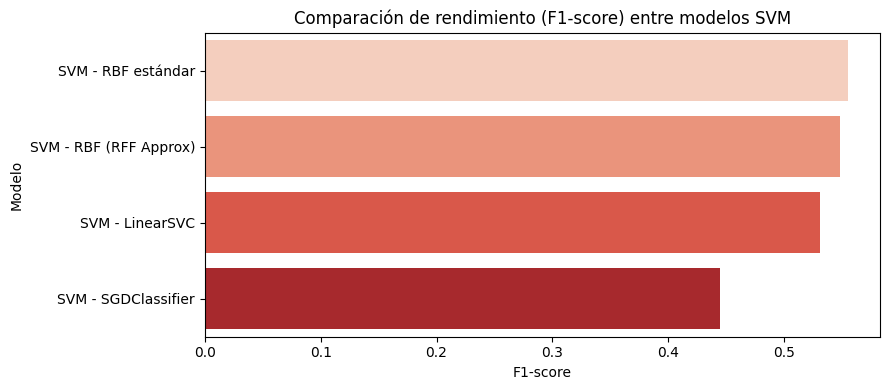

In [90]:
plt.figure(figsize=(9, 4))
sns.barplot(y="Modelo", x="F1", data=tabla_resultados, palette="Reds")
plt.title("Comparación de rendimiento (F1-score) entre modelos SVM")
plt.xlabel("F1-score")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_14552\2695625736.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="Tiempo (s)", data=tabla_resultados, palette="Reds")


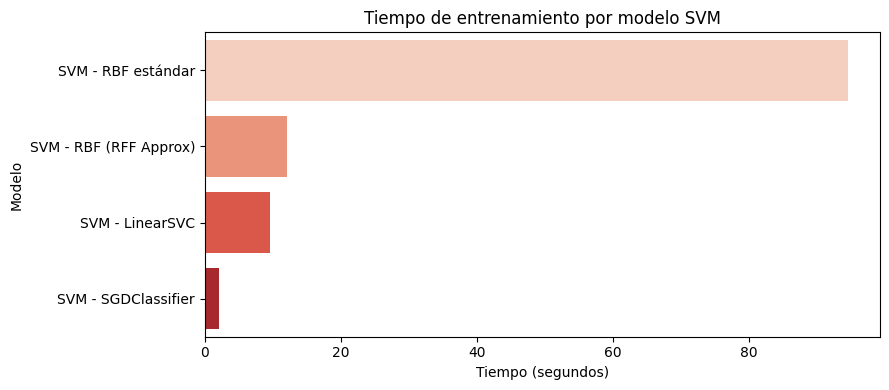

In [89]:
plt.figure(figsize=(9, 4))
sns.barplot(y="Modelo", x="Tiempo (s)", data=tabla_resultados, palette="Reds")
plt.title("Tiempo de entrenamiento por modelo SVM")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()